# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan z~tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rocie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*.
Trzecim argumentem jest odchyleniem standardowym. Wartość jest dob
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj probowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

if not os.path.exists("dom.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png --no-check-certificate
if not os.path.exists("lena.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/lena.bmp --no-check-certificate


In [44]:
def crossing(LoG, thr):
    result = np.zeros(LoG.shape)
    
    for y in range(1, result.shape[0] - 1):
        for x in range(1, result.shape[1] - 1):
            kernel = LoG[y - 1 : y + 2, x - 1 : x + 2]
            max_val, min_val = np.max(kernel), np.min(kernel)
            if np.sign(max_val) != np.sign(min_val):
                if LoG[y, x] > 0:
                    result[y, x] = LoG[y, x] + abs(min_val)
                elif LoG[y, x] < 0:
                    result[y, x] = abs(LoG[y, x]) + max_val

                    
    normalized = cv2.normalize(result, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    returned_thr, thresholded = cv2.threshold(normalized, thr, 255, cv2.THRESH_BINARY)
    return cv2.medianBlur(thresholded, 3)


Text(0.5, 1.0, 'crossing')

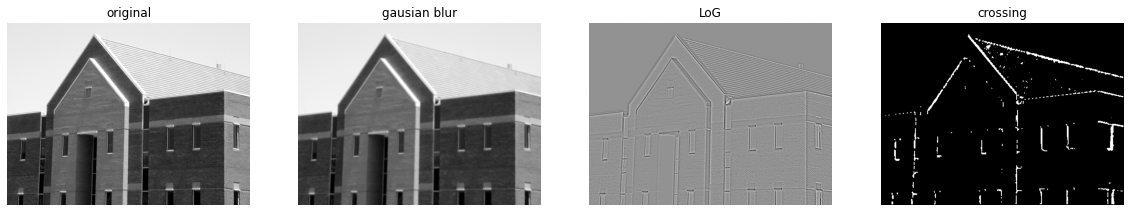

In [73]:
PATH = 'dom.png'
KERNEL_SIZE = (9, 9)
SIGMA = 1
THR = 90

img = cv2.imread(PATH, cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(img, KERNEL_SIZE, SIGMA)
LoG = cv2.Laplacian(blurred, cv2.CV_32F)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(img, 'gray')
axs[0].axis('off')
axs[0].set_title('original')
axs[1].imshow(blurred, 'gray')
axs[1].axis('off')
axs[1].set_title('gausian blur')
axs[2].imshow(LoG, 'gray')
axs[2].axis('off')
axs[2].set_title('LoG')
axs[3].imshow(crossing(LoG, THR), 'gray')
axs[3].axis('off')
axs[3].set_title('crossing')


## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w~1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj algorytm detekcji krawędziCanny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
Często krawędzie "pewne" nie są ciągłe.
Dlatego wykorzystuje się obraz $g_{NL}$ w następującej procedurze:
    - Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g_{NH}$.
W tym celu wykorzystaj listę współrzędnych `[row, col]`.
Do pobrania elementu z początku służy metoda `list.pop()`.
Do dodania elementu na koniec listy służy metoda `list.append(new)`.
    - Stwórz obraz, który będzie zawierał informację czy dany piksel został już odwiedzony.
    - Stwórz obraz, któy zawierać będzie wynikowe krawędzie.
Jej rozmiar jest równy rozmiarowi obrazu.
    - Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
W tym celu najlepiej sprawdzi się pętla `while`.
    - W każdej iteracji pobierz element ze stosu.
    - Sprawdź czy dany element został już odwiedzony.
    - Jeśli nie został, to:
        - Oznacz go jako odwiedzony,
        - Oznacz piksel jako krawędź w wyniku,
        - Sprawdź otoczenie piksela w obrazie $g_{NL}$,
        - Dodaj do stosu współrzędne otoczenia, które zawierają krawędź.
        Można to wykoanać np. pętlą po stworzonym otoczeniu.
7. Wyświetl obraz oryginalny, obraz $g_{NH} oraz obraz wynikowy.

    - zlokalizuj następny "nieodwiedzony" piksel krawędziowy $p$ na obrazie $g_{NH}$,
    - oznacz jako poprawne piksele wszystkie "potencjalne" połączone z $p$ (w oknie $3 \times 3$),
    - kontynuuj dla wszystkich piksli z $g_{NH}$,
    - zamień na 0 wszystkie piksele z $g_{NL}$, które nie zostały oznaczone jako poprawne.

Ostateczny rezultat detekcji krawędzi powstaje jako suma $g_{NH}$ i $g_{NL}$ (poprawnych).

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować wbardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj algorytm Cannego.

In [116]:
SOBEL_HORIZONTAL = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
SOBEL_VERTICAL = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

WEAK = np.int32(25)
STRONG = np.int32(255)

def is_between(a, x, b):
    return min(a, b) < x < max(a, b)

def sobel(img):
    g_x = cv2.filter2D(img, -1, SOBEL_HORIZONTAL / SOBEL_HORIZONTAL.shape[0] ** 2)
    g_y = cv2.filter2D(img, -1, SOBEL_VERTICAL / SOBEL_VERTICAL.shape[0] ** 2)
    magnitude = np.hypot(g_x, g_y)
    magnitude = magnitude / magnitude.max() * 255
    angle = np.arctan2(g_x, g_y)
    return magnitude, angle

def nonmaximal_supression(gradient, angle):
    result = np.zeros(gradient.shape, dtype=np.int32)
    
    # radians to degrees
    angle = angle * 180 / np.pi
    angle[angle < 0] += 180
    
    for y in range(1, gradient.shape[0] - 1):
        for x in range(1, gradient.shape[1] - 1):
            try:
                q, r = 255, 255
                pix = gradient[y, x]

                if is_between(0, pix, 22.5) or is_between(157.5, pix, 180):
                    q, r = gradient[y, x + 1], gradient[y, x - 1]
                elif is_between(22.5, pix, 67.5):
                    q, r = gradient[y + 1, x - 1], gradient[y - 1, x + 1]
                elif is_between(67.5, pix, 112.5):
                    q, r = gradient[y + 1, x], gradient[y - 1, x]
                elif is_between(112.5, pix, 157.5):
                    q, r = gradient[y - 1, x - 1], gradient[y + 1, x + 1]

                if gradient[y, x] >= q and gradient[y, x] >= r:
                    result[y, x] = gradient[y, x]
                else: result[y, x] = 0
            except IndexError:
                pass
    return result


def threshold(img, high_thresh, low_thresh):
    result = np.zeros(img.shape, dtype=np.int32)
    
    strong_i, strong_j = np.where(img >= high_thresh)
    zeros_i, zeros_j = np.where(img < low_thresh)
    weak_i, weak_j = np.where((img <= high_thresh) & (img >= low_thresh))
    
    result[strong_i, strong_j] = STRONG
    result[weak_i, weak_j] = WEAK
    
    return result


def hysteresis(img):
    
    for y in range(1, img.shape[0] - 1):
        for x in range(1, img.shape[1] - 1):
            if img[y, x] == WEAK:
                try:
                    if np.any(img[y - 1 : y + 2, x - 1 : x + 2] == STRONG):
                        img[y, x] = STRONG
                    else: img[y, x] = 0
                except IndexError:
                    pass
    return img
                

(-0.5, 556.5, 416.5, -0.5)

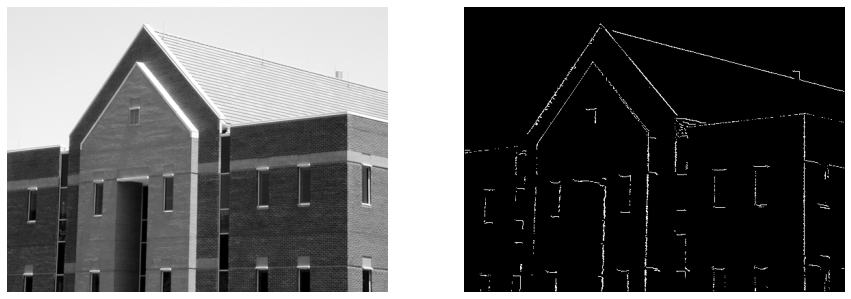

In [134]:
PATH = 'dom.png'
KERNEL_SIZE = (5, 5)
SIGMA = 1
HIGH_THRESH = 70
LOW_THRESH = 20

img = cv2.imread(PATH, cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(img, KERNEL_SIZE, SIGMA)
magnitude, angle = sobel(blurred)
nonmax = nonmaximal_supression(magnitude, angle)
thresholded = threshold(nonmax, HIGH_THRESH, LOW_THRESH)
final = hysteresis(thresholded)


fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(img, 'gray')
axs[0].axis('off')
axs[1].imshow(final, 'gray')
axs[1].axis('off')

# plt.imshow(img, 'gray')
# plt.show()
# plt.imshow(blurred, 'gray')
# plt.show()
# plt.imshow(magnitude.astype('uint8'), 'gray')
# plt.show()
# plt.imshow(final, 'gray')
# plt.show()





## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z własną implementacją.

(-0.5, 556.5, 416.5, -0.5)

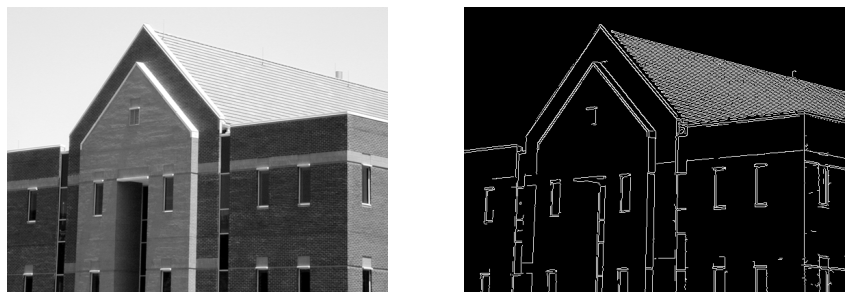

In [133]:
THRESH_1 = 120
THRESH_2 = 200
img = cv2.imread(PATH, cv2.IMREAD_GRAYSCALE)
canny = cv2.Canny(img, THRESH_1, THRESH_2, None, 3, 1)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(img, 'gray')
axs[0].axis('off')
axs[1].imshow(canny, 'gray')
axs[1].axis('off')